# 使用torchvision的數據集

In [1]:
import mlearn as mlearn
from mlearn import functional as F
from mlearn import layers
from mlearn.optimizers import SGD, RMSProp, Momentum, Adam
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from mlearn.utils import DataLoader
from mlearn.utils import pre_F as P
import sys
from time import time

# 加載數據集

In [12]:
train = datasets.MNIST("datasets", train=True, download=True)

test = datasets.MNIST("datasets", train=False, download=True)

pre = [P.normalize_MinMax]
# pre = [P.normalize]
# pre = []
trainset = DataLoader((train.data,train.targets),batch_size=32,shuffle=True,
                      preprocessing=pre)
testset = DataLoader((test.data, test.targets), batch_size=32, shuffle=True,
                    preprocessing=pre)

In [13]:
class Simple_Net(mlearn.Module):
    def __init__(self):
        super(Simple_Net,self).__init__()
        self.dense1 = layers.Dense(784,300)
        self.dense2 = layers.Dense(300,10)

        
    def forward(self, inputs):
        o = self.dense1(inputs)
        o = F.tanh(o)
        o = self.dense2(o)
        o = F.relu(o)
        return o

In [14]:
class Net(mlearn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.dense1 = layers.Dense(784,500)
        self.dense2 = layers.Dense(500,256)
        self.dense3 = layers.Dense(256,128)
        self.dense4 = layers.Dense(128, 64)
        self.dense5 = layers.Dense(64 , 10)
        
    def forward(self, inputs):
        o = self.dense1(inputs)
        o = F.relu(o)
        o = self.dense2(o)
        o = F.relu(o)
        o = self.dense3(o)
        o = F.relu(o)
        o = self.dense4(o)
        o = F.leaky_relu(o,0.01)
        o = self.dense5(o)
        o = F.leaky_relu(o, 0.01)
        return o
net = Net()
net.load_wb('saved_param/Param4Test.pkl')
hist = []

网络参数加载完毕


In [15]:
# 如果features没有进行规一化处理的话,并且激活函数全部使用relu家族会导致权重爆炸 (Weights -> Nan)
# Solution: 规一化或者加入非线性激活函数可以解决 如 Tanh
# Tanh 会使神经网络拟合速度降低, 并且速度不如 ReLU
# 但是Tanh可以避免梯度消失,对于一些规模很小的神经网络

def fit(hist):
    optimizer = Adam(net,0.001)
    EPOCHS = 10
    start = time()
    for epoch in range(EPOCHS):
        running_loss = 0.0
#         bar = " "*20
        for i, batch in enumerate(trainset, 0):
            features, labels = batch
            net.zero_grad()
            predict = net(features.reshape(-1,784))
            loss = F.cross_entropy(predict, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data
#             print(f"\r{epoch+1}/{EPOCHS} Batch %-4d/1874  [{bar}] -> AVG Loss %.5f"%(i,running_loss/(i+1)), end="")
#             sys.stdout.flush()
        print(f"{epoch+1}/{EPOCHS}  [AVG Loss -> %.5f]"%(running_loss/(i+1)))
        hist.append(running_loss/(i+1))
    print(f"Finished in {time() - start}")
    print('trainning completed!')
fit(hist)

1/10  [AVG Loss -> 0.44371]
2/10  [AVG Loss -> 0.09050]
3/10  [AVG Loss -> 0.06110]
4/10  [AVG Loss -> 0.04394]
5/10  [AVG Loss -> 0.03529]
6/10  [AVG Loss -> 0.03109]
7/10  [AVG Loss -> 0.02512]
8/10  [AVG Loss -> 0.02570]
9/10  [AVG Loss -> 0.02029]
10/10  [AVG Loss -> 0.01907]
Finished in 156.5337255001068
trainning completed!


Accuracy 0.98003


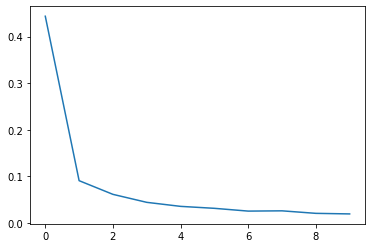

In [16]:
correct = 0
total = 0

for batch in testset:
    features, labels = batch
    o = net(features.reshape(-1,784))
    predict = []
    for x in o.data:
        predict.append(np.argmax(x))
    for b in predict == labels.data:
        if b:
            correct += 1
    total += 32
print("Accuracy %.5f"%(correct / total))

plt.plot(hist)
plt.show()